In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
import os
import json
from ipywidgets import widgets
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display, clear_output

plt.style.use("ggplot")

In [2]:
competition = 'asl-signs'

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('..') / 'input'  / 'competition'
    # !pip install -Uqq fastai
else:
    import zipfile, kaggle
    path = Path.home() / '.data' / 'asl-signs'
    if not path.exists():
        path.mkdir(exist_ok=True)
        kaggle.api.competition_download_cli(competition, path=path)
        zipfile.ZipFile(path / f'{competition}.zip').extractall(path)

In [3]:
with open(path / 'sign_to_prediction_index_map.json') as f:
    sign_labels = json.load(f)

In [4]:
train = (pd.read_csv(path / 'train_with_meta.csv')
         .assign(idx=lambda x: x.participant_id.astype(str) + '_' + x.sequence_id.astype(str))
         .set_index('idx')
        )
train.head()

path  \
idx                                                               
26734_1000035562  train_landmark_files/26734/1000035562.parquet   
28656_1000106739  train_landmark_files/28656/1000106739.parquet   
16069_100015657    train_landmark_files/16069/100015657.parquet   
25571_1000210073  train_landmark_files/25571/1000210073.parquet   
62590_1000240708  train_landmark_files/62590/1000240708.parquet   

                  participant_id  sequence_id   sign  cnt_partial_nulls  \
idx                                                                       
26734_1000035562           26734   1000035562   blow                0.0   
28656_1000106739           28656   1000106739   wait                0.0   
16069_100015657            16069    100015657  cloud                0.0   
25571_1000210073           25571   1000210073   bird                0.0   
62590_1000240708           62590   1000240708   owie                0.0   

                  cnt_partial_nulls_by_frame  face  left_hand  pose  \
idx                                                                   
26734_1000035562                         0.0    23          0    23   
28656_1000106739                         0.0    11          0    11   
16069_100015657                          0.0   105         28   105   
25571_1000210073                         0.0    12          0    12   
62590_1000240708                         0.0    18          0    18   

                  right_hand  total_frames  
idx                                         
26734_1000035562          11            23  
28656_1000106739           2            11  
16069_100015657            0           105  
25571_1000210073          12            12  
62590_1000240708          18            18

# Frame Distribution by Word

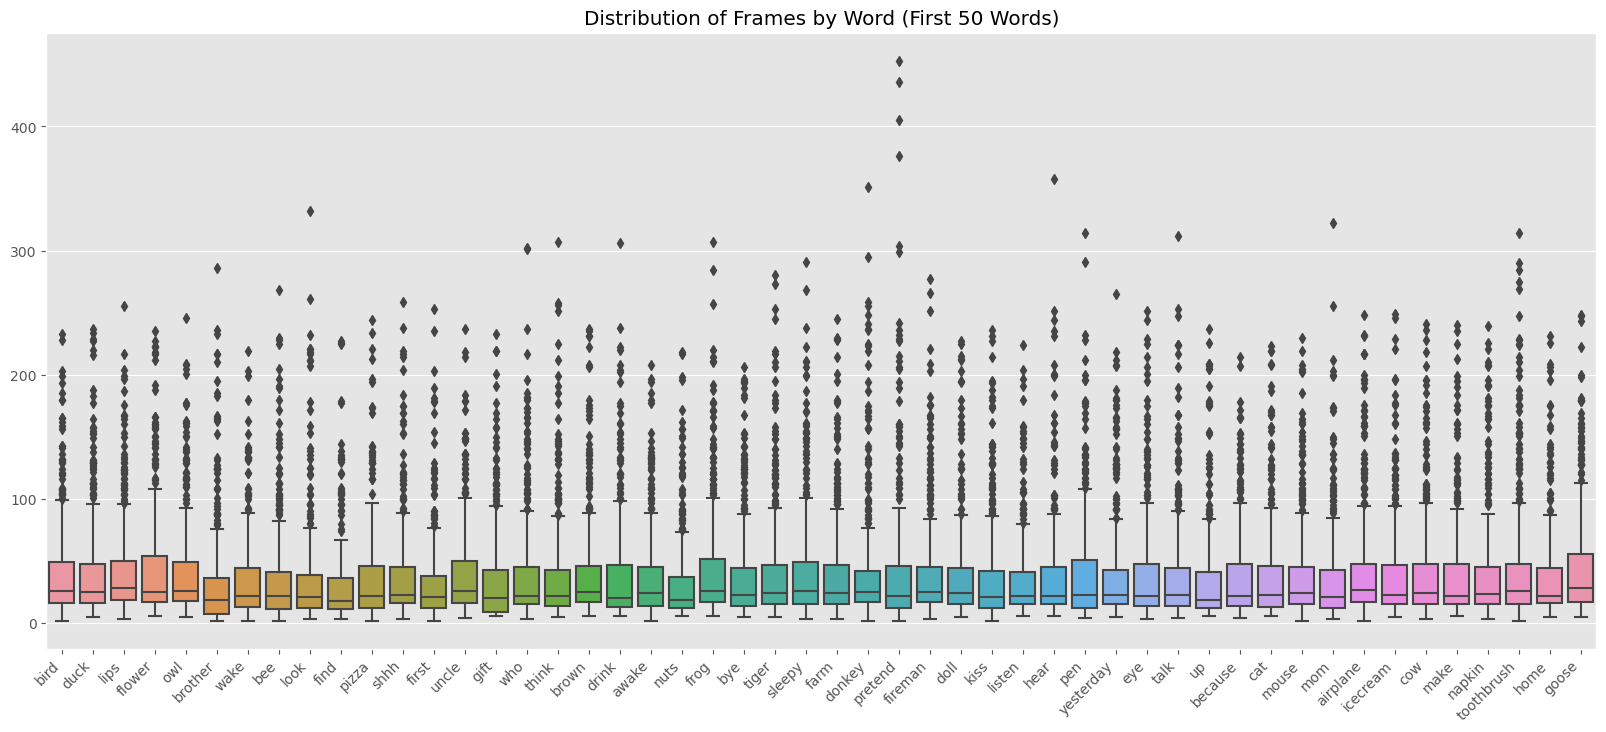

In [6]:
signs = train.sign.value_counts().reset_index()

sign_subset = signs.iloc[0:0+50]['index'].tolist()

data = train.loc[train.sign.isin(sign_subset), :]

fig, ax = plt.subplots(figsize=(20, 8))
sns.boxplot(data=data, x='sign', y='total_frames', ax=ax)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
ax.set(title='Distribution of Frames by Word (First 50 Words)', xlabel='', ylabel='')

plt.show()

In [52]:
title = 'Frame Distributions for "{}"'

def validate():
    return textbox.value in signs

def response(change):
    sign = textbox.value
    mask = train.sign == sign
    data = train.loc[mask, :]

    with g.batch_update():
        g.data[0].x = data.right_hand
        g.data[1].x = data.pose
        g.layout.title = dict(text=title.format(sign), x=0.5)

        clear_output(wait=True)
    display(vbox)
    g.show()

signs = train.sign.sort_values().unique().tolist()
textbox = widgets.Dropdown(
    description='Word', value='bird', options=signs
)

sign = 'bird'
mask = train.sign == sign
data = train.loc[mask, :]

trace1 = go.Histogram(x=data.right_hand, name='Right Hand', opacity=0.5)
trace2 = go.Histogram(x=data.pose, name='Pose', opacity=0.5)

g = go.FigureWidget(data=[trace1, trace2],
                    layout=go.Layout(
                        title=dict(
                            text=title.format(sign),
                            x=0.5
                        ),
                        barmode='overlay'
                    ))


textbox.observe(response, names='value')

container = widgets.HBox([textbox])
vbox = widgets.VBox([container, g])
display(vbox)
g.show()

In [ ]:
We can see that most entries have a majority of their right hand frames <= 4.

In [51]:
avg_percent_lt_50 = train.groupby('sign').right_hand.apply(lambda g: (g <= 4).sum() / g.size).mean()
print(f"Signs have on average {avg_percent_lt_50:0.0%} of records with less than 4 right hand frames")

Signs have on average 52% of records with less than 4 right hand frames


In [66]:
avg_percent_lt_50 = train.groupby('sign').right_hand.apply(lambda g: (g <= 1).sum() / g.size).mean()
print(f"Signs have on average {avg_percent_lt_50:0.0%} of records with less than no right hand frames")

Signs have on average 44% of records with less than no right hand frames


In [67]:
avg_percent_lt_50 = train.groupby('sign').left_hand.apply(lambda g: (g <= 1).sum() / g.size).mean()
print(f"Signs have on average {avg_percent_lt_50:0.0%} of records with less than no left hand frames")

Signs have on average 57% of records with less than no left hand frames


# Left & Right Hand  Correlations

In [57]:
fig = px.scatter(train, x="left_hand", y="right_hand")
fig.show()

# Particpant ID

# Left & Right Hand  Correlations by Participant Avg.

In [62]:
fig = px.scatter(train, x="left_hand", y="right_hand")

POSES = ['face', 'left_hand', 'pose', 'right_hand']
g = train.groupby(['participant_id'])
medians = (g[POSES + ['total_frames']]
           .median()
          )

px.scatter(medians, x="left_hand", y="right_hand")
fig.show()

face  left_hand  pose  right_hand  total_frames
participant_id                                                 
2044            15.0        0.0  15.0        11.0          15.0
4718            21.0        0.0  21.0        11.0          21.0
16069           25.0       15.0  25.0         0.0          25.0
18796           14.0        0.0  14.0        11.0          14.0
22343           26.0       16.0  26.0         0.0          26.0
25571           12.0        0.0  12.0         9.0          12.0
26734           30.0        0.0  30.0        22.0          30.0
27610           30.0       16.0  31.0         0.0          31.0
28656           30.0        0.0  30.0        16.0          30.0
29302           33.0        0.0  33.0        12.0          33.0
30680           10.0        0.0  12.0         7.0          12.0
32319           26.0       18.0  26.0         0.0          26.0
34503           51.0       24.0  51.0         0.0          51.0
36257           20.0       14.0  20.0         0.0          20.0
37055           22.0        3.0  22.0         0.0          22.0
37779            9.5        0.0   9.5         8.0           9.5
49445           43.0        0.0  44.0        22.0          44.0
53618           16.0        0.0  16.0        10.0          16.0
55372           22.0       17.0  22.0         0.0          22.0
61333           30.0       21.0  30.0         0.0          30.0
62590           18.0        0.0  18.0        15.0          18.0